# PREDICTOR FOR OBI SAMPLES WITH HUMAN MODEL


Training starting from best saved model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


In [2]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)


#INIT 
data_dir=''
fname=''
models_dir=''

Running on CoLab
Num GPUs Available: 1
Found GPU at: /device:GPU:0
Thu May 19 05:44:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                     

In [3]:
########################################
# PARAMS
########################################
padding=True
model_name = 'LSTMBidiAttention9'
fname = 'obi_DL_Pad_W50_BALANCED_1_1_CODED.csv'

numchannels=2

if numchannels==3:
   categories_size=60
else:
   categories_size=20

if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../data/datasets/OBI/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/OBI/W50'
    models_dir= '/content/drive/MyDrive/MODELS'
#########################################

Mounted at /content/drive


In [4]:
saved_model =  model_name+'.h5'
savedmodelfile = os.path.join(models_dir, saved_model)
print("MODEL FILE: {}".format(savedmodelfile))

MODEL FILE: /content/drive/MyDrive/MODELS/LSTMBidiAttention9.h5


In [5]:
datafile = os.path.join(data_dir, fname)
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=";")
print("shape dataraw={}".format(dataraw.shape))

DATASET: /content/drive/MyDrive/DATASETS/OBI/W50/obi_DL_Pad_W50_BALANCED_1_1_CODED.csv
shape dataraw=(208792, 104)


In [6]:
#dataset=dataraw[dataraw.columns[3:len(dataraw.columns)]]
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']

random_seed=2022
samples_to_test = 200000
fraction_to_test=samples_to_test/(dataraw.shape[0])
print("fraction_to_test={}".format(fraction_to_test))
x_out, x_test, y_out, y_test = train_test_split(X, Y, test_size=fraction_to_test, random_state=random_seed)

print("x_test.shape={}".format(x_test.shape))
print("y_test.shape={}".format(y_test.shape))
print("TEST LABELS:")
print(y_test.value_counts())

#free memory
del dataraw
del X
del Y

fraction_to_test=0.9578911069389632
x_test.shape=(200000, 101)
y_test.shape=(200000,)
TEST LABELS:
0    100090
1     99910
Name: EDITING, dtype: int64


Recover saved model

In [7]:
#Load the trained model from disk
import os.path

if os.path.exists(savedmodelfile):
    model = tf.keras.models.load_model(savedmodelfile)
    # Show the model architecture
    model.summary()
else:
    print("ERROR model {} nor found ".format(savedmodelfile))           



Model: "LSTMBidiAttention9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                                                                 

In [8]:
#PREDICTIONS
#DataGenerator converts on the fly from raw data to one-hot
from RNAEd import DataGenerator

num_nucleosides = x_test.shape[1]
num_tokens = categories_size

pred_generator = DataGenerator(x_test, y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )
model_prediction = model.predict(pred_generator,verbose=1)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

200000/200000 [==============================] - 1695s 8ms/step


In [9]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(200000, 101)
(200000,)
(200000, 1)
(200000, 1)


In [10]:
#METRICS QUALITY CLASSIFICATION

print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL LSTMBidiAttention9
---------------------------------
Kappa: 0.065
              precision    recall  f1-score   support

           0       0.52      0.99      0.68    100090
           1       0.87      0.08      0.14     99910

    accuracy                           0.53    200000
   macro avg       0.69      0.53      0.41    200000
weighted avg       0.69      0.53      0.41    200000



Text(80.90000000000006, 0.5, 'Truth Editing')

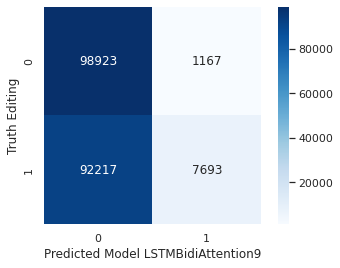

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
plt.figure()
cm = confusion_matrix(y_test,model_prediction_binary)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,cmap="Blues")
plt.xlabel('Predicted Model '+ model_name)
plt.ylabel('Truth Editing')